In [1]:
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-y2j1bkeg
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-y2j1bkeg
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-jp809b5x/pyfolio_54f167d7823b4b20a5155c1bb2c5ffee
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-jp809b5x/pyfolio_54f167d7823b4b20a5155c1bb2c5ffee
     |████████████████████████████████| 1.6 MB 23.6 MB/s eta 0:00:01
     |████████████████████████████████| 152 kB 67.1 MB/s eta 0:00:01
     |████████████████████████████████| 280 kB 74.0 MB/s eta 0:00:01
     |████████████████████████████████| 52 kB 2.5 MB/s  eta 0:00:01
     |████████████████████████████████| 107 kB 54.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 54.9 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 87.9 MB/s eta 0:00:01
     |████████████████████████████████| 5.5 MB 67.7 

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv
from finrl.model.models import DRLAgent,DRLEnsembleAgent
from finrl.trade.backtest import backtest_stats, get_baseline, backtest_plot

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [4]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [5]:
# from config.py start_date is a string
config.START_DATE

'2000-01-01'

In [6]:
print(config.NAS_100_TICKER)

['AMGN', 'AAPL', 'AMAT', 'INTC', 'PCAR', 'PAYX', 'MSFT', 'ADBE', 'CSCO', 'XLNX', 'QCOM', 'COST', 'SBUX', 'FISV', 'CTXS', 'INTU', 'AMZN', 'EBAY', 'BIIB', 'CHKP', 'GILD', 'NLOK', 'CMCSA', 'FAST', 'ADSK', 'CTSH', 'NVDA', 'GOOGL', 'ISRG', 'VRTX', 'HSIC', 'BIDU', 'ATVI', 'ADP', 'ROST', 'ORLY', 'CERN', 'BKNG', 'MYL', 'MU', 'DLTR', 'ALXN', 'SIRI', 'MNST', 'AVGO', 'TXN', 'MDLZ', 'FB', 'ADI', 'WDC', 'REGN', 'LBTYK', 'VRSK', 'NFLX', 'TSLA', 'CHTR', 'MAR', 'ILMN', 'LRCX', 'EA', 'AAL', 'WBA', 'KHC', 'BMRN', 'JD', 'SWKS', 'INCY', 'PYPL', 'CDW', 'FOXA', 'MXIM', 'TMUS', 'EXPE', 'TCOM', 'ULTA', 'CSX', 'NTES', 'MCHP', 'CTAS', 'KLAC', 'HAS', 'JBHT', 'IDXX', 'WYNN', 'MELI', 'ALGN', 'CDNS', 'WDAY', 'SNPS', 'ASML', 'TTWO', 'PEP', 'NXPI', 'XEL', 'AMD', 'NTAP', 'VRSN', 'LULU', 'WLTW', 'UAL']


In [7]:
df = YahooDownloader(start_date = config.START_DATE,
                     end_date = '2021-01-19',
                     ticker_list = config.NAS_100_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [10]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2000-01-03,0.936384,1.004464,0.907924,0.860883,535796800.0,AAPL,0
1,2000-01-03,16.812500,16.875000,16.062500,16.274673,7384400.0,ADBE,0
2,2000-01-03,46.750000,46.937500,44.000000,30.033604,3655600.0,ADI,0
3,2000-01-03,42.428928,42.775894,41.189766,26.281422,2698899.0,ADP,0
4,2000-01-03,8.500000,8.656250,8.031250,8.052903,2845600.0,ADSK,0


In [11]:
df.tail()

,date,open,high,low,close,volume,tic,day
465811,2021-01-15,50.189999,52.119999,49.980000,51.209999,5866800.0,WDC,4
465812,2021-01-15,203.589996,207.229996,203.589996,206.024582,979900.0,WLTW,4
465813,2021-01-15,108.430000,108.430000,105.769997,106.230003,2836300.0,WYNN,4
465814,2021-01-15,63.410000,65.050003,63.040001,64.479050,3811600.0,XEL,4
465815,2021-01-15,139.570007,141.259995,136.149994,136.600006,2280200.0,XLNX,4


In [12]:
df.shape

(465816, 8)

In [13]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2000-01-03,0.936384,1.004464,0.907924,0.860883,535796800.0,AAPL,0
1,2000-01-03,16.812500,16.875000,16.062500,16.274673,7384400.0,ADBE,0
2,2000-01-03,46.750000,46.937500,44.000000,30.033604,3655600.0,ADI,0
3,2000-01-03,42.428928,42.775894,41.189766,26.281422,2698899.0,ADP,0
4,2000-01-03,8.500000,8.656250,8.031250,8.052903,2845600.0,ADSK,0


In [15]:
TECHNICAL_INDICATORS_LIST = ["macd", "tema", "boll_ub","boll_lb","rsi_30", "cci_30", "dx_30","close_30_sma","close_60_sma"]
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = TECHNICAL_INDICATORS_LIST,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)


Successfully added technical indicators
Successfully added turbulence index


In [16]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [17]:
processed_full.sample(5)

,date,tic,open,high,low,close,volume,day,macd,tema,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
481930,2013-05-01,PYPL,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
584261,2016-02-29,VRSN,85.400002,86.300003,84.449997,84.489998,1118600.0,0.0,1.770378,85.101529,87.636432,69.851567,56.134876,149.329493,25.620930,77.470666,81.907333,151.567425
723619,2020-01-07,FAST,35.869999,36.099998,35.650002,34.362728,3108300.0,1.0,0.098034,34.342149,36.108535,34.233208,50.848111,-46.994192,7.071466,34.769191,34.797735,174.335875
632247,2017-06-28,IDXX,162.919998,164.929993,162.440002,164.649994,557200.0,2.0,0.202701,164.180863,173.701481,157.517524,54.282590,-29.608640,8.707219,165.316668,162.562167,139.105083
432436,2011-12-19,ADSK,31.389999,31.389999,30.080000,30.200001,3965600.0,0.0,-0.386081,30.172987,35.923246,29.162754,45.592506,-134.182858,22.716208,33.058334,32.034833,96.659445


In [18]:
stock_dimension = len(processed_full.tic.unique())
state_space = 1 + 2*stock_dimension + len(TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 99, State Space: 1090


In [19]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 50_000_000/100, #Since in Indonesia the minimum number of shares per trx is 100, then we scaled the initial amount by dividing it with 100 
    "buy_cost_pct": 0.0019, #IPOT has 0.19% buy cost
    "sell_cost_pct": 0.0029, #IPOT has 0.29% sell cost
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

In [20]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)
train_start = '2000-01-01'
train_end = '2019-01-01'
val_test_start = '2019-01-01'
val_test_end = '2021-01-18'

ensemble_agent = DRLEnsembleAgent(df=processed_full,
                 train_period=(train_start,train_end),
                 val_test_period=(val_test_start,val_test_end),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)

In [26]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.01,
                    'learning_rate': 0.0005
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      "action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 50_000,
                      "learning_rate": 0.000005,
                      "batch_size": 128
                    }

timesteps_dict = {'a2c' : 100_000, 
                 'ppo' : 100_000, 
                 'ddpg' : 50_000
                 }


In [27]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

    

============Start Ensemble Strategy============
nan
turbulence_threshold:  1557.8473247419677
======Model training from:  2000-01-01 to  2019-01-02
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_4
------------------------------------
| time/                 |          |
|    fps                | 20       |
|    iterations         | 100      |
|    time_elapsed       | 24       |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -141     |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | -97.2    |
|    std                | 1        |
|    value_loss         | 1.17     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 20       |
|    iterations         | 200      |
|    

In [29]:
import pickle as pkl

with open('model_perf.pkl','wb+') as myfile:
    pkl.dump(df_summary,myfile)
    
with open('model_perf.pkl','rb+') as myfile:
    df_summary = pkl.load(myfile)

In [30]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2019-01-02,2019-04-03,PPO,0.380741,0.450406,0.306181
1,189,2019-04-03,2019-07-03,A2C,0.2456,-0.149893,0.06346
2,252,2019-07-03,2019-10-02,DDPG,-0.253235,-0.168261,0.039848
3,315,2019-10-02,2020-01-02,DDPG,0.192742,0.119079,0.486963
4,378,2020-01-02,2020-04-02,DDPG,-0.423401,-0.329991,-0.324609
5,441,2020-04-02,2020-07-02,DDPG,0.360459,0.382899,0.459114
6,504,2020-07-02,2020-10-01,DDPG,-0.207573,-0.06359,0.037635


In [32]:
unique_trade_date = processed_full[(processed_full.date > val_test_start)&(processed_full.date <= val_test_end)].date.unique()


In [2]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))


In [35]:
df_account_value

,account_value,date,daily_return,datadate
0,500000.000000,2019-04-03,NaN,2019-04-03
1,497906.634247,2019-04-04,-0.004187,2019-04-04
2,501586.411689,2019-04-05,0.007390,2019-04-05
3,501023.170684,2019-04-08,-0.001123,2019-04-08
4,496888.438431,2019-04-09,-0.008253,2019-04-09
...,...,...,...,...
436,704806.856521,2020-12-23,-0.004553,2020-12-23
437,707270.326705,2020-12-24,0.003495,2020-12-24
438,707271.968761,2020-12-28,0.000002,2020-12-28
439,710448.150817,2020-12-29,0.004491,2020-12-29


<AxesSubplot:>

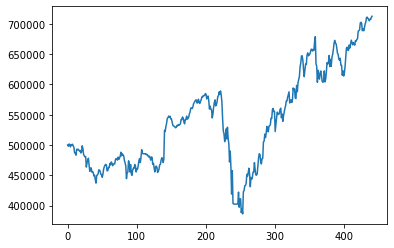

In [36]:
%matplotlib inline
df_account_value.account_value.plot()

In [37]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.224197
Cumulative returns     0.424754
Annual volatility      0.304944
Sharpe ratio           0.818223
Calmar ratio           0.651311
Stability              0.545561
Max drawdown          -0.344224
Omega ratio            1.174709
Sortino ratio          1.144238
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.035938
Daily value at risk   -0.037429
dtype: float64


==============Compare to IHSG===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 8)


Start date,2019-04-03
End date,2020-12-29
Total months,20
,Backtest
Annual return,22.286%
Cumulative returns,42.09%
Annual volatility,30.529%
Sharpe ratio,0.81
Calmar ratio,0.65
Stability,0.54
Max drawdown,-34.422%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,34.42,2020-02-19,2020-04-03,2020-07-20,109
1,12.86,2019-04-05,2019-06-03,2019-10-22,143
2,11.1,2020-09-02,2020-09-18,2020-12-01,65
3,6.85,2020-01-16,2020-01-31,2020-02-14,22
4,5.32,2020-08-06,2020-08-11,2020-08-17,8


Stress Events,mean,min,max
New Normal,0.10%,-11.80%,9.99%


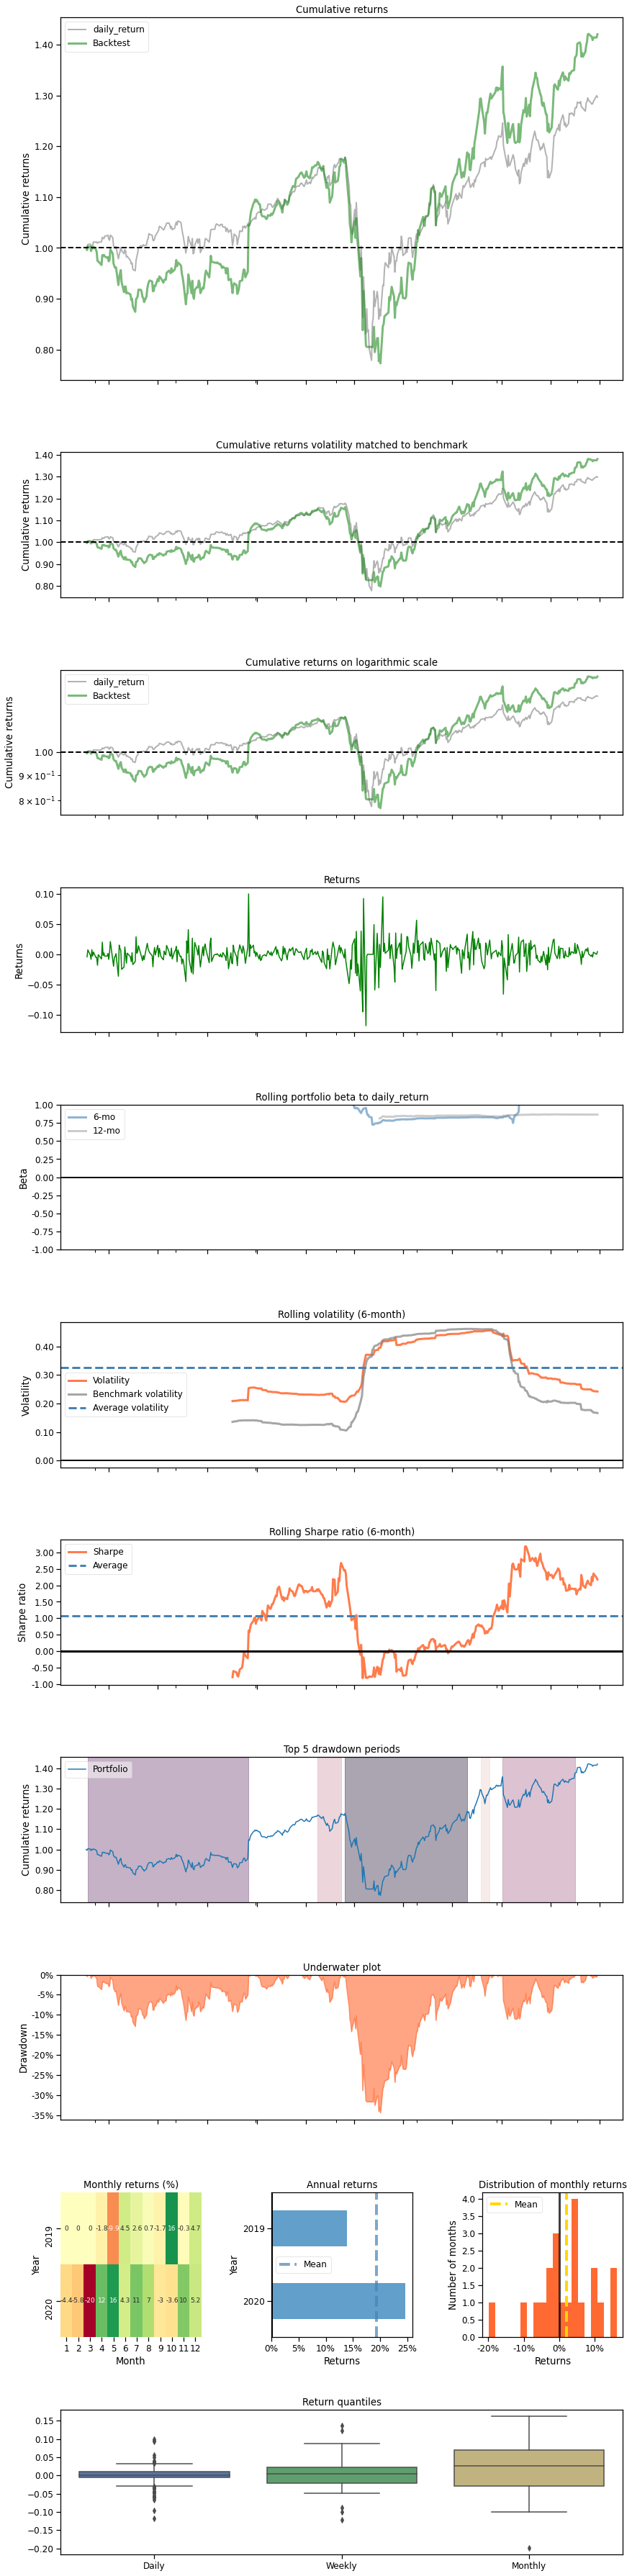

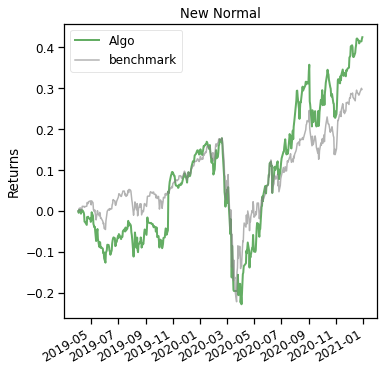

In [38]:
print("==============Compare to IHSG===========")
%matplotlib inline
backtest_plot(df_account_value, 
             baseline_ticker = '^GSPC', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

In [39]:
print("==============Get Baseline Stats===========")
baseline_perf_stats=get_baseline('^GSPC',
                                  start = df_account_value.loc[0,'date'],
                                  end = df_account_value.loc[len(df_account_value)-1,'date'])

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 8)
